In [20]:
from collections import Counter
import datetime
import numpy as np
import pandas as pd
import pickle
import itertools
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from gensim.utils import simple_preprocess
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import scale
from sklearn.metrics import classification_report,accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from textblob import TextBlob

In [3]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/kevin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
from sklearn.feature_extraction import text 

In [5]:
#Reads in a CSV file as a dataframe and drops null rows.
def import_reviews(filename):
    df = pd.read_csv(filename)
    if 'Unnamed: 0' in df.columns:
        df.drop(columns = 'Unnamed: 0', inplace=True)
    df = df.dropna()
    return df

In [417]:
#Reading in the reviews and doing text processing on them.
df = import_reviews('in_n_out_reviews')

df_text = text_preprocessing(df,1)

In [434]:
df_text.isnull().values.any()

False

In [419]:
df_text.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3578 entries, 0 to 3581
Data columns (total 5 columns):
useful           3578 non-null int64
text             3578 non-null object
tokens           3578 non-null object
length           3578 non-null int64
modeling_text    3578 non-null object
dtypes: int64(2), object(3)
memory usage: 167.7+ KB


In [15]:
#Saving the tokenized text to a dataframe for future use
df_text.to_csv('tokenized_text')

NameError: name 'df_text' is not defined

In [6]:
#Processes text to be used in topic modeling. Tokenizes and adds n-grams. Also adds the length
# of the review as a column.
def text_preprocessing(df, ngram):
    df['tokens'] = df['text'].apply(simple_preprocess)
    df_text = df[['useful','text', 'tokens']]
    df_text = df
    df_text = df_text.reset_index()
    df_text.drop(columns='index', inplace=True)
    df_text = df_text[(df_text.tokens.str.len() > 5)]
    df_text['useful'] = df_text['useful'].apply(lambda x: 1 if x > 0 else 0)
    df_text['length'] = df_text['text'].apply(len)
    if ngram > 1:
        df_text['grams'] = df_text['tokens'].apply(lambda x: find_ngrams(x, n=ngram))
        df_text['modeling_text_list'] = df_text['tokens'] + df_text['grams']
        df_text['modeling_text'] = df_text['modeling_text_list'].apply(lambda x:' '.join(x))
    else:
        df_text['modeling_text'] = df_text['tokens'].apply(lambda x:' '.join(x))
    return df_text

In [7]:
#Saves the results of my modeling to a csv
def save_metrics(metric_list, df):
    df.append(pd.DataFrame(metric_list))
    df.to_csv('metrics_dataframe')
    return True

In [8]:
#Reading in some text, I would overwrite csv files as I updated them so I no longer have the original.
df_topic_probs = import_reviews('lda_doc_topic_probs')

df = import_reviews('tokenized_text')

df_reviews = import_reviews('in_n_out_reviews')

df_user = import_reviews('user_info_subset')

In [154]:
#Trying to match up reviewer data with the review that they wrote. This was to add more features to model on.
df_user.columns = [['useful_sum', 'review_count', 'yelping_since', 'cool_sum', 'funny_sum',
       'compliment_cool', 'elite', 'user_id']]

df_reviews_user = pd.merge(df_reviews, df_user, how='left', on=['user_id'], sort=False)

df_user_with_text = df_reviews_user[['stars', 'text','useful_sum', 'review_count', 'yelping_since',
                                       'cool_sum', 'funny_sum', 'compliment_cool', 'elite']]

df_tokenized_user = text_preprocessing(df_user_with_text, 1)

df_text_user = pd.merge(df, df_tokenized_user, how='left', on=['text'], sort=False)

In [155]:
#I was getting different lengths for the two dataframes so I began to suspect that something wasn't working as
#intended
len(df), len(df_text_user)

(3582, 3578, 3582)

In [77]:
#Converting the day the user joined into the age of the account in days.
def days_old(date):
    date = datetime.datetime.strptime(date, "%Y-%m-%d")
    return (datetime.datetime.utcnow() - date).days
df_text_user['account_age'] = df_text_user['yelping_since'].apply(days_old)

In [156]:
#Making an account_age column in days
df_tokenized_user['account_age'] = df_tokenized_user['yelping_since'].apply(days_old)

In [81]:
#Saving my the user data matched with review dataframe.
df_tokenized_user.to_csv('my_lst_hope')

df_text_user.to_csv('user_info_subset')

In [90]:
len(df_topic_probs), len(df_text_user)

(3578, 3582)

In [738]:
# #Attempting to include POS as a feature! Doesn't work very well

# adjective = set(["JJ", "JJR", 'JJS'])
# adverb = set(["RB", "RBR", 'RBS'])
# adj_count = []
# adv_count = []
# for i in range(len(df)):
#     adj, adv, pn = 0, 0, 0
#     pos_list = TextBlob(df.iloc[i]['modeling_text']).pos_tags
#     temp_dict = Counter(pos_list[1])
#     for key in temp_dict:
#         value = temp_dict[key]
#         if key in adjective:
#             adj += value
#         elif key in adverb:
#             adv += value
#     adj_count.append(adj)
#     adv_count.append(adv)
# df_topic_probs['adjective'] = adj_count
# df_topic_probs['adv_count'] = adv_count

In [729]:
# df_topic_probs.groupby('useful')['adv_count', 'proper_n'].describe()

adv_count                                              proper_n       \
           count      mean       std  min  25%  50%  75%  max    count mean   
useful                                                                        
0         2237.0  0.088064  0.283452  0.0  0.0  0.0  0.0  1.0   2237.0  0.0   
1         1341.0  0.083520  0.276769  0.0  0.0  0.0  0.0  1.0   1341.0  0.0   

                                      
        std  min  25%  50%  75%  max  
useful                                
0       0.0  0.0  0.0  0.0  0.0  0.0  
1       0.0  0.0  0.0  0.0  0.0  0.0

In [180]:
df_topic_probs.to_csv('lda_doc_topic_probs')

In [179]:
#Adding polarity for each review with TextBlob
df_topic_probs['polarity'] = df['modeling_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [58]:
df_topic_probs.reset_index(inplace=True)

In [59]:
len(df_topic_probs), len(df['length'])

(3578, 3578)

In [17]:
df_test = df_topic_probs[df_topic_probs['polarity'].isnull()]

In [18]:
df_test

,index,0,1,2,length,useful,review_count,account_age,useful_sum,stars,funny_sum,compliment_cool,polarity


In [446]:
df_topic_probs = df_topic_probs.dropna()

In [447]:
len(df_topic_probs)

3578

In [13]:
#Function that creates ngrams
def find_ngrams(input_list, n):
    # Courtesy http://locallyoptimal.com/blog/2013/01/20/elegant-n-gram-generation-in-python/
    ngrams = zip(*[input_list[i:] for i in range(n)])
    flattened_ngrams = list(map(lambda x: '_'.join(x), ngrams))
    return flattened_ngrams

In [24]:
df_text.head()

,useful,text,tokens,grams,modeling_text_list,modeling_text
0,0,I was in the area running errands with my mom....,"[was, in, the, area, running, errands, with, m...","[was_in, in_the, the_area, area_running, runni...","[was, in, the, area, running, errands, with, m...",was in the area running errands with my mom we...
1,0,We had to try this place after hearing all the...,"[we, had, to, try, this, place, after, hearing...","[we_had, had_to, to_try, try_this, this_place,...","[we, had, to, try, this, place, after, hearing...",we had to try this place after hearing all the...
2,0,Good quick burgers not sure about all the hype...,"[good, quick, burgers, not, sure, about, all, ...","[good_quick, quick_burgers, burgers_not, not_s...","[good, quick, burgers, not, sure, about, all, ...",good quick burgers not sure about all the hype...
3,1,"Always hot, fresh, and delicious. This is the ...","[always, hot, fresh, and, delicious, this, is,...","[always_hot, hot_fresh, fresh_and, and_delicio...","[always, hot, fresh, and, delicious, this, is,...",always hot fresh and delicious this is the bur...
4,0,There is not a cleaner and healthier burger pl...,"[there, is, not, cleaner, and, healthier, burg...","[there_is, is_not, not_cleaner, cleaner_and, a...","[there, is, not, cleaner, and, healthier, burg...",there is not cleaner and healthier burger plac...


In [21]:
#Adding custom stopwords
stopword = set(stopwords.words('english'))
stopword = stopword.union(set(['food', 'this', 'place', 'the', 'of', 'is', 'came', 'was', 'for', 'have', 'had'
                           ,'and', 'get', 'one', 'food', 'guy','?','!','place', 'good', 'fries','burger', 'burgers',
                            'got', 'eat','great', 'us', 'asked', 'service', 'back', 'time', 'like', 'vegas', 'go',
                            'try', 'animal', 'style', 'double', 'good', 'just', 'always', 'location', 'fresh',
                              'east', 'coast', 'order', 'ordered', 'fast']))

In [23]:
#Creating count vectors
vocabulary = set(itertools.chain.from_iterable(df_text['modeling_text_list']))
vectorizer = CountVectorizer(vocabulary=vocabulary, stop_words= stopword)

In [113]:
#Creating an empty list to store results of my models
metric_list = []

In [66]:
"""Creates train and test data with the count vectors to be used for Multinomial Naive Bayes modelling"""
# X_train, X_test, y_train, y_test = train_test_split(df_text['modeling_text'], df_text['useful'], test_size=0.3, random_state = 15)

# # Create X, y vectors
# X_train = vectorizer.fit_transform(X_train).todense()

# X_test = vectorizer.transform(X_test).todense()

# # Create, train model
# nb = MultinomialNB()
# nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [67]:
y_scoreMNB=nb.predict_proba(X_test)[:,1]
fpr_MNB, tpr_MNB,_ = roc_curve(y_test, y_scoreMNB)

In [68]:
#MultinomilaNB
y_prednb = nb.predict(X_test)
scores = nb.score(X_test, y_test)
nb.score(X_train,y_train), scores

(0.9888178913738019, 0.6312849162011173)

In [77]:
#Saving results to a dictionary
metrics_MNB = (metrics_to_dict('MultinomialNB', , y_test, nb.predict(X_test),
                                   nb.score(X_train, y_train), nb.score(X_test, y_test),
                                   'Null', 0))

In [315]:
len(df_topic_probs)

3578

In [93]:
#Adding results to my existing results dataframe
df_metric_list.append(pd.DataFrame(metrics_MNB, index=range(1))).to_csv('metrics_dataframe')

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [72]:
#Create a dataframe to store gridsearch results
df_metric_list = pd.read_csv('metrics_dataframe')

In [334]:
#Read in LSI topic probabilities, add length of review and polarity for modelling.
df_topic_probs = pd.read_csv('lsi_topic_probs')
df_topic_probs['length'] = df_topic_probs_lda['length']
df_topic_probs['polarity'] = df_topic_probs_lda['polarity']

In [319]:
df_topic_probs.head(1)

,Unnamed: 0,modeling_text,1,2,3,length
0,0,was in the area running errands with my mom we...,1.50829,-0.43658,-0.31543,731


In [375]:
#Seperates X and y for modeling and creates train, test sets
X = df_topic_probs[['3', '1', '2', 'length']]
y = df_topic_probs_lda['useful']
X = scale(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 15)

In [377]:
len(X_train), len(X_test), len(y_train)

(2504, 1074, 2504)

In [340]:
#GausianNB for predicting with length and n-topics as features
params = {'priors' : [None]}
gb = GridSearchCV(GaussianNB(),params, scoring='roc_auc', cv=5)
gb.fit(X_train, y_train)
y_predgb = gb.predict(X_test)
gb_scores = gb.score(X_test, y_test)

In [341]:
y_scoregb=gb.predict_proba(X_test)[:,1]

In [342]:
y_probgb = gb.predict_proba(X_test)

In [343]:
fpr, tpr,_ = roc_curve(y_test, y_scoregb)

In [346]:
gb_scores, print(change_threshold(y_probgb, 0.55))

             precision    recall  f1-score   support

          0       0.71      0.89      0.79       689
          1       0.63      0.34      0.44       385

avg / total       0.68      0.69      0.66      1074



(0.6966618287373004, None)

In [204]:
#Add results to list
n=3
metric_list.append(metrics_to_dict('GaussianNB', n, y_test, gb.predict(X_test),
                                   gb.score(X_train, y_train), gb.score(X_test, y_test), "Null",1))

In [384]:
#Grid search for logistic regression
log_params = {'C': [ 1e-2,1e-1, 1,10,100],
             'penalty': ['l1','l2']}
log = GridSearchCV(LogisticRegression(), log_params, scoring='roc_auc', cv = 5)
log.fit(X_train,np.ravel(y_train))
y_scorelog=log.predict_proba(X_test)[:,1]
y_problog = log.predict_proba(X_test)
coefficients = list(log.best_estimator_.coef_)
fpr_log, tpr_log,_ = roc_curve(y_test, y_scorelog)
roc_auc = auc(fpr_log, tpr_log)
log.score(X_train, y_train), log.score(X_test, y_test), log.best_params_

(0.6946654071118896, 0.724041995740109, {'C': 1, 'penalty': 'l2'})

In [420]:
log.best_estimator_

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [417]:
#Observing precision with different thresholds.
print(change_threshold(y_problog, 0.8))

             precision    recall  f1-score   support

          0       0.65      0.99      0.79       689
          1       0.78      0.05      0.09       385

avg / total       0.70      0.65      0.54      1074



In [409]:
#Add logistic regression metrics to list
n=3
metric_list.append(metrics_to_dict('Logistic Regression(lsi)', n, y_test,
                                   log.predict(X_test), log.score(X_train, y_train), log.score(X_test, y_test),
                                   log.best_params_, 1))

In [326]:
#Gradient boosting grid search
gb_param = {'n_estimators' : [25,100,200],
        'max_depth' : [2,3,10],
        'learning_rate': [1e-2, 1e-1, 1]}
gradboost = GridSearchCV(GradientBoostingClassifier(), gb_param,scoring = 'roc_auc', cv= 5)
gradboost.fit(X_train, y_train)
y_score_gboost=gradboost.predict_proba(X_test)[:,1]
y_prob_gboost = gradboost.predict_proba(X_test)
fpr_gboost, tpr_gboost,_ = roc_curve(y_test, y_score_gboost)
roc_auc = auc(fpr_gboost, tpr_gboost)

gradboost.score(X_train, y_train), gradboost.score(X_test, y_test), gradboost.best_params_

(0.7154217075886824,
 0.7206491621585962,
 {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 25})

In [332]:
y_predgb = gradboost.predict(X_test)

In [333]:
#Observing precision with different thresholds
print(change_threshold(y_prob_gboost, 0.5))

             precision    recall  f1-score   support

          0       0.69      0.91      0.79       689
          1       0.63      0.27      0.38       385

avg / total       0.67      0.68      0.64      1074



In [336]:
#Add gradient boosting metrics to list
n = 3
metric_list.append(metrics_to_dict('Gradient Boosting(lsi)', n, y_test, gradboost.predict(X_test),
                                   gradboost.score(X_train, y_train), gradboost.score(X_test, y_test),
                                   gradboost.best_params_, 1))

In [747]:
#Saving results
save_metrics(metric_list)

True

In [41]:
#Returns the classification report for different thresholds, n.
def change_threshold(y_prob, n):
    y_pred = [1 if x >= n else 0 for x in y_prob[:, 1]]
    return classification_report(y_test, y_pred)

In [70]:
#Returns a dictionary of metrics for each algorithm
def metrics_to_dict(algorithm, n_topics, y_test, y_pred, auc_train, auc_test, params, sa):
    if not sa:
        sa = 0
    results = {}
    prec = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test,y_pred)
    f1 = metrics.f1_score(y_test,y_pred)
    results['Algorithm'] = algorithm
    results['Parameters'] = params
    results['Number of Topics'] = n_topics
    results['Polarity'] = sa
    results['Auc_train'] = auc_train
    results['Auc_test'] = auc_test
    results['Precision'] = prec
    results['Recall'] = recall
    
    return results

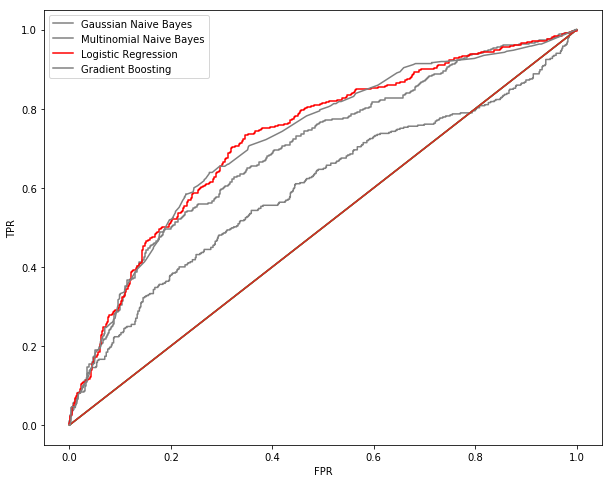

In [354]:
#Making AUC curve for all the algorithms I used.
plt.figure(figsize=[10,8])
plt.plot([0,1],[0,1])

plt.plot(fpr,tpr, label='Gaussian Naive Bayes', color = 'grey')
plt.xlabel('FPR')
plt.ylabel('TPR')

plt.plot([0,1],[0,1])
plt.plot(fpr_MNB,tpr_MNB, label='Multinomial Naive Bayes', color = 'grey')

plt.plot([0,1],[0,1])
plt.plot(fpr_log,tpr_log, label='Logistic Regression', color = 'red')

plt.plot([0,1],[0,1])
plt.plot(fpr_gboost,tpr_gboost, label='Gradient Boosting', color = 'grey')

plt.legend()

In [85]:
df_text.groupby('useful').count()

,text,tokens,modeling_text,length
useful,,,,
0,2221,2221,2221,2221
1,1338,1338,1338,1338


In [421]:
#Sorting by AUC scores to see which algorithm performed the best and with which hyperparameters
pd.DataFrame(metric_list).sort_values('Auc_test', ascending = False)

,Algorithm,Auc_test,Auc_train,Number of Topics,Parameters,Polarity,Precision,Recall
10,Logistic Regression(lsi),0.724042,0.694665,3,"{'C': 1, 'penalty': 'l2'}",1,0.633880,0.301299
12,Logistic Regression(lsi),0.724042,0.694665,3,"{'C': 1, 'penalty': 'l2'}",1,0.633880,0.301299
11,Gradient Boosting(lsi),0.720649,0.715422,3,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti...",1,0.626506,0.270130
8,Logistic Regression,0.719220,0.694776,3,{'C': 1},1,0.638614,0.335065
9,Gradient Boosting,0.717790,0.709373,3,"{'learning_rate': 0.01, 'max_depth': 2, 'n_est...",1,0.639456,0.244156
5,Logistic Regression,0.717460,0.694987,3,{'C': 1},0,0.645000,0.335065
4,Gradient Boosting,0.717236,0.709121,3,"{'learning_rate': 0.01, 'max_depth': 2, 'n_est...",0,0.639456,0.244156
3,Gradient Boosting,0.715811,0.712171,15,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti...",0,0.616279,0.275325
2,Logistic Regression,0.713191,0.695834,15,{'C': 10},1,0.605381,0.350649
1,GaussianNB,0.673866,0.661497,15,Null,1,0.363198,0.979221


In [196]:
df_metric_list.fillna(0).sort_values('Auc_test', ascending = False)

,Unnamed: 0,Algorithm,Auc_test,Auc_train,Number of Topics,Parameters,Polarity,Precision,Recall
15,15,Logistic Regression,0.724664,0.693508,3,{'C': 0.1},1.0,0.647668,0.324675
4,4,Logistic Regression,0.722625,0.693229,2,{'C': 10},0.0,0.635417,0.316883
7,7,Logistic Regression,0.720529,0.694396,3,{'C': 10},0.0,0.647668,0.324675
8,8,Gradient Boosting,0.720121,0.700771,3,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti...",0.0,0.652482,0.238961
10,10,Logistic Regression,0.719756,0.693229,4,{'C': 20},0.0,0.639594,0.327273
16,16,Gradient Boosting,0.718996,0.701180,3,"{'learning_rate': 0.01, 'max_depth': 2, 'n_est...",1.0,0.652482,0.238961
2,2,Gradient Boosting,0.718463,0.698783,5,"{'learning_rate': 0.1, 'max_depth': 1, 'n_esti...",0.0,0.652482,0.238961
11,11,Gradient Boosting,0.718084,0.703504,4,"{'learning_rate': 0.01, 'max_depth': 2, 'n_est...",0.0,0.652482,0.238961
5,5,Gradient Boosting,0.717443,0.700158,2,"{'learning_rate': 0.01, 'max_depth': 2, 'n_est...",0.0,0.652482,0.238961
13,13,Logistic Regression,0.711907,0.697092,10,{'C': 1},0.0,0.612245,0.311688


In [272]:
#Making confusion matrix
class_names = ['Not Useful','Useful']
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True')
    plt.xlabel('Predicted')

In [214]:
y_pred = log.predict(X_test)

Confusion matrix, without normalization
[[684   5]
 [367  18]]


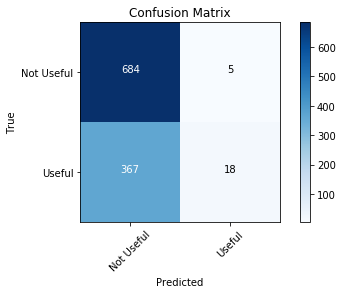

In [419]:
#Creating confusion matrix.
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion Matrix')